# Predicting Scope 3 Emissions
### XGBoost and Random Forest Machine Learning Models
##### (*Post-Outlier Removal and Post-Skew Transformation*)

In [239]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import math
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
%matplotlib inline

In [241]:
# Load final csv file into a DataFrame
df = pd.read_csv('Final_GHG_Data.csv')
df.head()

,account_name,account_id,Year,incorporated_country,Primary activity,Primary sector,Market_Cap_USD,Third_party_verification,Revenue_USD,ebitda_USD,...,totalDebt_USD,totalEquity_USD,Scope_3_emissions_type,Scope_3_emissions_amount,Quantile_Scope_3_emissions,BoxCox_Scope_3_emissions,Robust_Scope_3_emissions,country_ghg_avg,country_population_avg,country_gdp_avg
0,3i Group,44,2018,United Kingdom,Asset managers,Financial services,9548123536.43,Third-party verification or assurance process ...,1728470000.00,1565910000.00,...,730250000.00,10044430000.00,Purchased goods and services,17.62,-2.05,2.95,-0.12,428.77,67346924.78,3038320070320.49
1,3i Group,44,2018,United Kingdom,Asset managers,Financial services,9548123536.43,Third-party verification or assurance process ...,1728470000.00,1565910000.00,...,730250000.00,10044430000.00,Fuel-and-energy-related activities (not includ...,61.42,-1.75,4.28,-0.12,428.77,67346924.78,3038320070320.49
2,3i Group,44,2018,United Kingdom,Asset managers,Financial services,9548123536.43,Third-party verification or assurance process ...,1728470000.00,1565910000.00,...,730250000.00,10044430000.00,Waste generated in operations,57.21,-1.77,4.20,-0.12,428.77,67346924.78,3038320070320.49
3,3i Group,44,2018,United Kingdom,Asset managers,Financial services,9548123536.43,Third-party verification or assurance process ...,1728470000.00,1565910000.00,...,730250000.00,10044430000.00,Business travel,2549.33,-0.64,8.45,-0.10,428.77,67346924.78,3038320070320.49
4,3i Group,44,2018,United Kingdom,Asset managers,Financial services,9548123536.43,Third-party verification or assurance process ...,1728470000.00,1565910000.00,...,730250000.00,10044430000.00,Employee commuting,3.90,-2.38,1.38,-0.12,428.77,67346924.78,3038320070320.49


In [243]:
df.columns.unique()

Index(['account_name', 'account_id', 'Year', 'incorporated_country',
       'Primary activity', 'Primary sector', 'Market_Cap_USD',
       'Third_party_verification', 'Revenue_USD', 'ebitda_USD',
       'grossProfit_USD', 'netIncome_USD', 'cashAndCashEquivalents_USD',
       'shortTermInvestments_USD', 'longTermInvestments_USD',
       'totalAssets_USD', 'totalLiabilities_USD', 'totalInvestments_USD',
       'totalDebt_USD', 'totalEquity_USD', 'Scope_3_emissions_type',
       'Scope_3_emissions_amount', 'Quantile_Scope_3_emissions',
       'BoxCox_Scope_3_emissions', 'Robust_Scope_3_emissions',
       'country_ghg_avg', 'country_population_avg', 'country_gdp_avg'],
      dtype='object')

## Correlation Analysis
Before handling nulls, I want to check for correlation on each feature to Scope 3 emissions amount and all of the transformed columns.

Because the machine learning model will need to predict by Emission type, I will attempt to create a multi-bar chart that shows the average correlation of all types for all 4 of the Scope 3 emissions amounts (Original and 3 transformed amounts from the previous process).


Number of Emission Types analyzed: 17


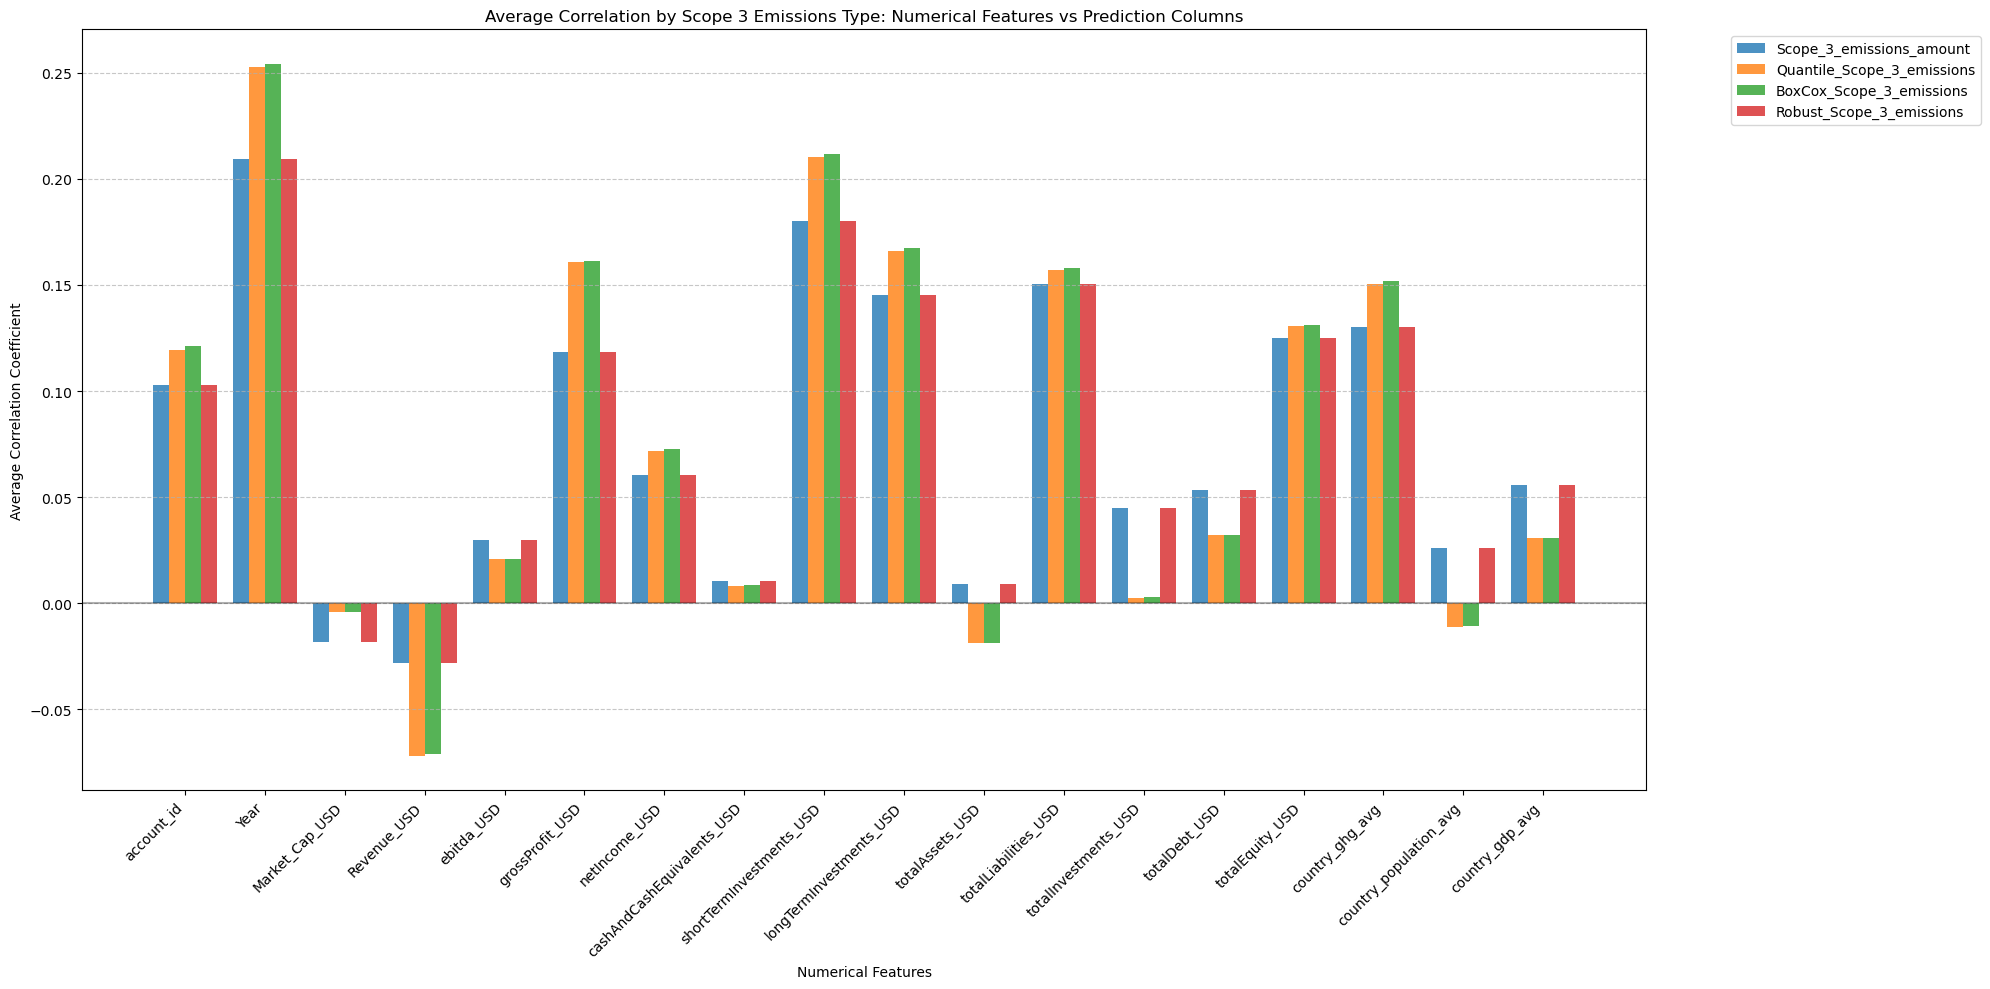

In [246]:
# Define the amount columns
pred_cols = ['Scope_3_emissions_amount', 'Quantile_Scope_3_emissions', 
            'BoxCox_Scope_3_emissions', 'Robust_Scope_3_emissions']

# Select numerical columns (excluding prediction columns)
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = [col for col in numerical_cols if col not in pred_cols]

# Initialize dictionary to store correlations
correlations_by_type = {}

# Calculate correlations for each Emissions type
for type in df['Scope_3_emissions_type'].unique():
    type_df = df[df['Scope_3_emissions_type'] == type]
    
    # Calculate correlations for each prediction column
    correlations_dict = {}
    for pred_col in pred_cols:
        correlations_dict[pred_col] = type_df[numerical_cols].corrwith(type_df[pred_col])
    
    correlations_by_type[type] = pd.DataFrame(correlations_dict)

# Calculate average correlations across all types
avg_correlations = pd.concat(correlations_by_type.values()).groupby(level=0).mean()

# Create the grouped bar chart
plt.figure(figsize=(20, 10))

# Set up the positions for the bars
x = np.arange(len(numerical_cols))
width = 0.2

# Plot bars for each prediction column
for i, pred_col in enumerate(pred_cols):
    plt.bar(x + (i - 1.5) * width, 
           avg_correlations[pred_col], 
           width, 
           label=pred_col,
           alpha=0.8)

# Customize the plot
plt.xlabel('Numerical Features')
plt.ylabel('Average Correlation Coefficient')
plt.title('Average Correlation by Scope 3 Emissions Type: Numerical Features vs Prediction Columns')
plt.xticks(x, numerical_cols, rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.tight_layout()

# Print number of types used in analysis
print(f"\nNumber of Emission Types analyzed: {len(df['Scope_3_emissions_type'].unique())}")

##### Result
Looking at the average for all emission types, there isn't really any strong correlation to the features. Of course account_id and Year are not features. The negative correlation for Revenue is interesting. To move forward, in the final step, I will drop any features with less than .1 correlation. The Box Cox and Quantile transformed amounts correlate best overall and the Robut correlates the same as the original amount, which is expected. To move forward I am going to drop the fields that have the least correlation to the transformed amounts. Before I drop, I will also encode the categorical columns and check the correlation.

## Feature Engineering and Modeling

Most Machine Learning models require data encoding for categorical values. There are 2 main encoding methods used:
1. Label encoding
2. One hot encoding

Label encoding assigns a numerical value to every value in a categorical column. This method essentially converts a unique string into a unique number. This route can be problematic to the algorithm if the model assigns value to the numbers beyond categorical limitation. For instance, primary activity has over 50 values. It's safe to assume the model might interpret a value of 1 differently than a value of 50. 

One hot encoding converts every categorical value in each column to a binary value. For machine learning, this is the more ideal option, as it allows every category to be represented by its own binary feature. This prevents the model from assuming an ordinal relationship or ranking  between categories, which can cause inaccurate predictions. Because this dataset includes categorical columns wih many categories, one hot encoding will result in hundreds of features in order to capture every possible categorical value. This will likey result in overly high dimensionality and accumulated feature noise with very little correlation for reliable predictions.

Before deciding which columns to keep for training, I want to encode the categorical features and analyze for any possible correlation.

#### *Label Encode Third Party Verification and Examine Correlation*

In [251]:
# Create a copy of the Third_party_verification column
df['Third_party_verification_encoded'] = df['Third_party_verification'].copy()

# Label encode the column
le = LabelEncoder()
df['Third_party_verification_encoded'] = le.fit_transform(df['Third_party_verification_encoded'])

# Define the emission columns
emission_cols = ['Scope_3_emissions_amount', 'Quantile_Scope_3_emissions',
                'BoxCox_Scope_3_emissions', 'Robust_Scope_3_emissions']

# Calculate correlations
correlations = df[emission_cols].corrwith(df['Third_party_verification_encoded'])

# Print detailed information
print("=== Label Encoding Reference ===")
for i, label in enumerate(le.classes_):
    print(f"{label}: {i}")

print("\n=== Correlation Values ===")
for col in emission_cols:
    print(f"{col}: {correlations[col]:.4f}")

# Print value counts of original and encoded values
print("\n=== Value Counts ===")
print("Original Values:")
print(df['Third_party_verification'].value_counts())
print("\nEncoded Values:")
print(df['Third_party_verification_encoded'].value_counts())

=== Label Encoding Reference ===
No emissions data provided: 0
No third-party verification or assurance: 1
Question not applicable: 2
Third-party verification or assurance process in place: 3
nan: 4

=== Correlation Values ===
Scope_3_emissions_amount: 0.0200
Quantile_Scope_3_emissions: 0.0757
BoxCox_Scope_3_emissions: 0.0758
Robust_Scope_3_emissions: 0.0200

=== Value Counts ===
Original Values:
Third_party_verification
Third-party verification or assurance process in place    34692
No third-party verification or assurance                   8788
No emissions data provided                                  297
Question not applicable                                     278
Name: count, dtype: int64

Encoded Values:
Third_party_verification_encoded
3    34692
1     8788
0      297
2      278
4       24
Name: count, dtype: int64


#### *One Hot Encode Primary Sector and Examine Correlation*


=== Average Absolute Correlation by Emission Measure ===
Scope_3_emissions_amount     0.02
Quantile_Scope_3_emissions   0.03
BoxCox_Scope_3_emissions     0.03
Robust_Scope_3_emissions     0.02
dtype: float64


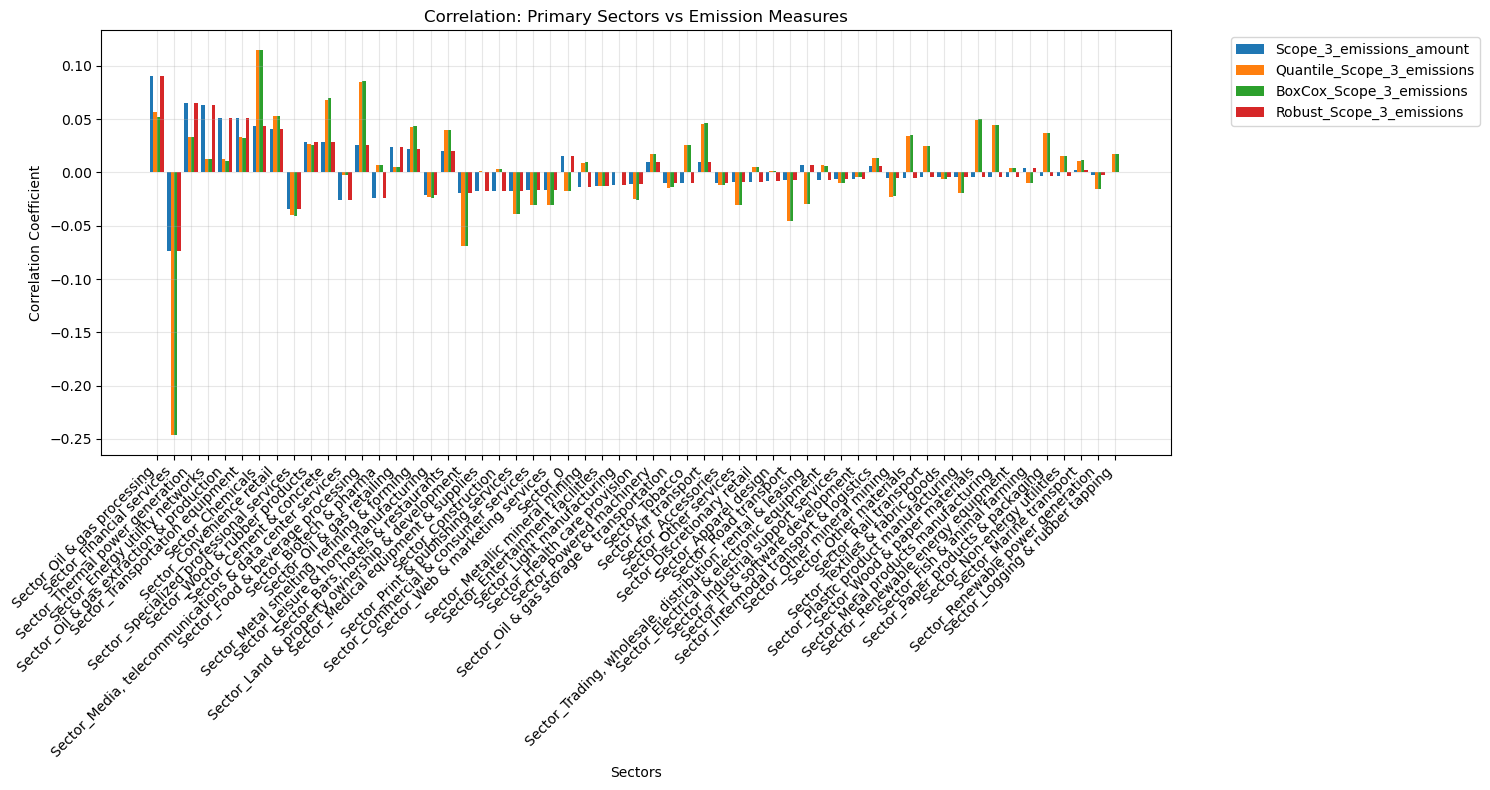

In [254]:
# One-hot encode Primary_sector using panda get dummies
one_hot = pd.get_dummies(df['Primary sector'], prefix='Sector')

# Define the emission columns
emission_cols = ['Scope_3_emissions_amount', 'Quantile_Scope_3_emissions',
                'BoxCox_Scope_3_emissions', 'Robust_Scope_3_emissions']

# Calculate correlations for each one-hot encoded column
correlations = pd.DataFrame()
for emission in emission_cols:
    correlations[emission] = one_hot.corrwith(df[emission])

# Sort correlations by absolute value of Scope_3_emissions_amount
correlations = correlations.reindex(
    correlations['Scope_3_emissions_amount'].abs().sort_values(ascending=False).index
)

# Create a grouped bar plot
plt.figure(figsize=(15, 8))
x = np.arange(len(correlations.index))
width = 0.2

for i, col in enumerate(emission_cols):
    plt.bar(x + (i - 1.5) * width, correlations[col], width, label=col)

plt.xlabel('Sectors')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation: Primary Sectors vs Emission Measures')
plt.xticks(x, correlations.index, rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()


# Calculate average absolute correlation for each emission measure
print("\n=== Average Absolute Correlation by Emission Measure ===")
avg_abs_corr = correlations.abs().mean()
print(avg_abs_corr.round(4))

#### *One Hot Encode Primary Activity and Examine Correlation*


=== Average Absolute Correlation by Emission Measure ===
Scope_3_emissions_amount     0.01
Quantile_Scope_3_emissions   0.02
BoxCox_Scope_3_emissions     0.02
Robust_Scope_3_emissions     0.01
dtype: float64


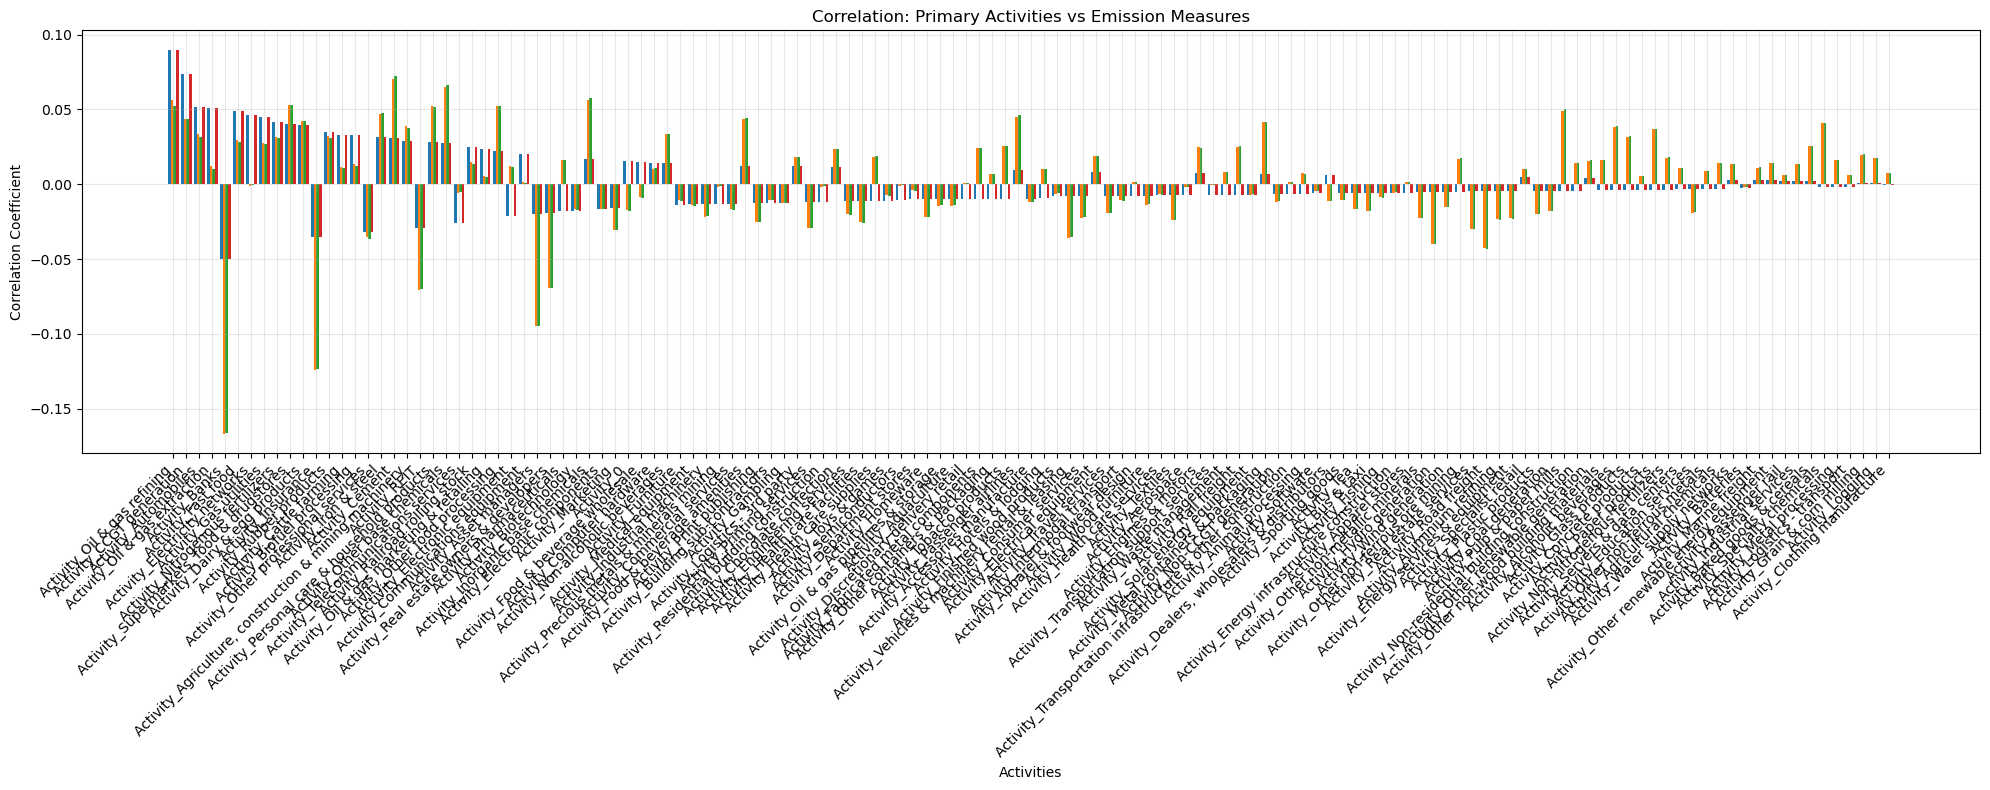

In [257]:
# One-hot encode Primary activity using pandas get dummies
one_hot = pd.get_dummies(df['Primary activity'], prefix='Activity')

# Define the emission columns
emission_cols = ['Scope_3_emissions_amount', 'Quantile_Scope_3_emissions',
                'BoxCox_Scope_3_emissions', 'Robust_Scope_3_emissions']

# Calculate correlations for each one-hot encoded column
correlations = pd.DataFrame()
for emission in emission_cols:
    correlations[emission] = one_hot.corrwith(df[emission])

# Sort correlations by absolute value of Scope_3_emissions_amount
correlations = correlations.reindex(
    correlations['Scope_3_emissions_amount'].abs().sort_values(ascending=False).index
)

# Create a grouped bar plot
plt.figure(figsize=(20, 8))
x = np.arange(len(correlations.index))
width = 0.2

for i, col in enumerate(emission_cols):
    plt.bar(x + (i - 1.5) * width, correlations[col], width, label=col)

plt.xlabel('Activities')
plt.ylabel('Correlation Coefficient')
plt.title('Correlation: Primary Activities vs Emission Measures')
plt.xticks(x, correlations.index, rotation=45, ha='right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Calculate average absolute correlation for each emission measure
print("\n=== Average Absolute Correlation by Emission Measure ===")
avg_abs_corr = correlations.abs().mean()
print(avg_abs_corr.round(4))

The categorical fields, when encoded, do not offer much correlation directly to emissions amounts. Because these features have so many categories, I do not want to risk high-dimensionality when there is little strong and consistent correlation, so I will drop Primary Sector and Primary Activity. Emission type is interesting because there is some correlation on a few of the types. I will also drop third party verification as it does not provide any importance.

#### Drop categorical features and features with the least correlation

In [32]:
drop_columns = [   'Market_Cap_USD'
                   ,'Revenue_USD'
                   ,'cashAndCashEquivalents_USD'
                   ,'totalInvestments_USD'
                   ,'totalAssets_USD'
                   ,'totalLiabilities_USD'
                   ,'Third_party_verification'
                   ,'Primary sector'
                   ,'Primary activity'
                   ,'incorporated_country'
                   ,'account_name'
                   ]
df = df.drop(columns=drop_columns)
df.describe()

,account_id,Year,ebitda_USD,grossProfit_USD,netIncome_USD,shortTermInvestments_USD,longTermInvestments_USD,totalDebt_USD,totalEquity_USD,Scope_3_emissions_amount,Quantile_Scope_3_emissions,BoxCox_Scope_3_emissions,Robust_Scope_3_emissions,country_ghg_avg,country_population_avg,country_gdp_avg,Third_party_verification_encoded
count,44079.000000,44079.000000,3.779900e+04,3.779900e+04,3.779900e+04,3.779900e+04,3.779900e+04,3.779900e+04,3.779900e+04,4.407900e+04,44079.000000,44079.000000,44079.000000,43990.000000,4.407900e+04,4.407900e+04,44079.000000
mean,18490.415073,2020.691055,3.166308e+09,7.154089e+09,1.522890e+09,3.946544e+09,1.369155e+10,1.205342e+10,1.140095e+10,7.541206e+05,0.008851,10.898929,4.692897,2020.043630,1.911141e+08,7.490542e+12,2.575285
std,29222.097829,1.702396,7.375009e+09,1.458088e+10,4.880889e+09,3.127004e+10,6.825788e+10,3.438719e+10,2.274114e+10,3.302482e+06,0.991377,3.766444,21.076803,2692.445035,2.930367e+08,8.835235e+12,0.827407
min,44.000000,2018.000000,-9.289400e+10,-2.699258e+10,-1.680588e+10,-1.414534e+12,-1.626800e+10,0.000000e+00,-1.073900e+10,2.000000e-03,-5.199338,-5.867133,-0.119984,1.981020,6.453412e+04,7.583005e+09,0.000000
25%,7374.000000,2019.000000,4.154140e+08,9.290000e+08,1.197610e+08,0.000000e+00,5.690000e+07,9.701640e+08,1.831418e+09,2.313000e+03,-0.667501,8.335369,-0.105222,412.740377,5.172400e+07,1.553189e+12,3.000000
50%,14709.000000,2021.000000,1.141344e+09,2.388233e+09,4.490000e+08,1.444000e+07,4.006353e+08,3.253740e+09,4.474547e+09,1.880000e+04,0.011916,10.805304,0.000000,1173.044363,1.258077e+08,4.185212e+12,3.000000
75%,21641.000000,2022.000000,2.941382e+09,6.388800e+09,1.285750e+09,2.646000e+08,1.940378e+09,9.387576e+09,1.111567e+10,1.590010e+05,0.672529,13.423624,0.894778,3265.433643,3.315243e+08,4.772504e+12,3.000000
max,832061.000000,2023.000000,1.305410e+11,1.740620e+11,9.980300e+10,4.505814e+11,1.229707e+12,7.756765e+11,3.278780e+11,5.199799e+07,5.199338,21.073533,331.736885,13105.528962,1.410932e+09,2.383859e+13,4.000000


### Remove NULLS
Now that the features have been finalized, I will remove any account that has a null observation. It is possible to utilize the null parameter in XGBoost and the imputer in Random Forest, but as a start, I want a clean and consistent dataset for these intial models to build from. 

In [35]:
# Create a summary dataframe to analyze nulls
summary_df = pd.DataFrame({
    'Data_Type': df.dtypes,
    'Null_Count': df.isnull().sum(),
    'Null_Percentage': (df.isnull().sum() / len(df) * 100).round(2),})

print("\nDataFrame Summary:")
print(summary_df)

# Print total null count
print("\nTotal null values in DataFrame:", df.isnull().sum().sum())

# How many accounts have at least 1 null value?
null_accounts = df[df.isnull().any(axis=1)]['account_id'].nunique()
print(f"Number of accounts with at least one null value: {null_accounts}")


DataFrame Summary:
                                 Data_Type  Null_Count  Null_Percentage
account_id                           int64           0             0.00
Year                                 int64           0             0.00
ebitda_USD                         float64        6280            14.25
grossProfit_USD                    float64        6280            14.25
netIncome_USD                      float64        6280            14.25
shortTermInvestments_USD           float64        6280            14.25
longTermInvestments_USD            float64        6280            14.25
totalDebt_USD                      float64        6280            14.25
totalEquity_USD                    float64        6280            14.25
Scope_3_emissions_type              object           0             0.00
Scope_3_emissions_amount           float64           0             0.00
Quantile_Scope_3_emissions         float64           0             0.00
BoxCox_Scope_3_emissions           float64  

#### *Remove Accounts with at least one NULL observation*

In [38]:
# Get initial unique account count
initial_accounts = df['account_id'].nunique()
initial_account_list = set(df['account_id'].unique())

# Remove rows with any null values
df_clean = df.dropna(axis=0, how='any')

# Get final unique account count
final_accounts = df_clean['account_id'].nunique()
final_account_list = set(df_clean['account_id'].unique())

# Calculate removed accounts
removed_accounts = initial_account_list - final_account_list

# Print summary statistics
print(f"Initial number of unique accounts: {initial_accounts}")
print(f"Final number of unique accounts: {final_accounts}")
print(f"Number of unique accounts removed: {len(removed_accounts)}")
print(f"Percentage of unique accounts removed: {(len(removed_accounts) / initial_accounts * 100):.2f}%")

# Print sample of removed accounts (if needed)
print(f"\nSample of 5 removed account_ids (if any):")
print(list(removed_accounts)[:5] if removed_accounts else "No accounts removed")

# Verify no null values remain
print("\nVerifying no null values remain:")
null_check = df_clean.isnull().sum()
print(null_check[null_check > 0] if len(null_check[null_check > 0]) > 0 else "No null values remaining")

Initial number of unique accounts: 1108
Final number of unique accounts: 969
Number of unique accounts removed: 139
Percentage of unique accounts removed: 12.55%

Sample of 5 removed account_ids (if any):
[22534, 37382, 15373, 31759, 31761]

Verifying no null values remain:
No null values remaining


In [40]:
# Reassign to original dataframe
df = df_clean

# Create a point in time of this original dataframe
df_original = df

# Machine Learning
I believe the models that best suit the nature of this data include:
#### 1. **XGBoost**
#### 2. **Random Forest**

Both models work well for the follwing reasons:

- Both are able to handle complex data relationships, which is a characteristic of Scope 3 emissions data.
- Able to capture non-linear relationships and interactions between variables.
- Robust to outliers, which common in emissions data and are less prone to overfitting.
- Work well with mixed data types (numerical and categorical), which is common in emissions reporting.
- Feature Importance: Both provide clear insights into which factors most influence emissions and can help identify key areas for emissions reduction.
- Scope 3 data frequently has gaps due to reporting challenges. While missing data was removed from the final dataset, it would be worthwhile to also test the models without data removal and compare the results as both models do well with handling missing values.
    - Random Forest can operate with missing data without imputation
    - XGBoost has built-in methods for missing value handling

##### **Model Design**
The algorithms will train on a time-series of all previous years in conjunction with numerical features in order to predict the most recent observation (Year 2023) within each Emission type.

##### **MAE (Mean Absolute Error)**
Performance will be analyzed using MAE. MAE measures the average magnitude of errors between predicted and actual values, without considering their direction (high or low). It is best in this prediction scenario because:

- The absolute scale of errors matters, as the absolute difference between actual and predicted emission amounts is highly important.
- MAE is in the same unit as the emission amount and both over and under-predictions are equally important.
- Direct, interpretable results and error measurements are needed in this scenario (MAE is more interpretable than percentage-based errors).
- Outliers exist but shouldn't dominate the error metric (MAE is more robust to outliers than squared metrics, such as MSE and RMSE).

### XGBoost

#### *Build the Model*

In [165]:
# Create empty lists to store results
mae_scores = []
emission_types = []
max_year_actuals = []
max_year_predictions = []

# Define numerical columns and gather features
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
feature_cols = [col for col in numerical_cols 
               if col not in ['Scope_3_emissions_amount', 'Year']]
selected_features = ['Year'] + feature_cols

# Dictionary to store results for each emission type
results_dict = {}

# Loop through each unique emission type
for emission_type in df['Scope_3_emissions_type'].unique():
    # Filter data for current emission type
    type_df = df[df['Scope_3_emissions_type'] == emission_type].copy()
    
    # Get the maximum year for this emission type
    max_year = type_df['Year'].max()
    
    # Split into train and test
    train_df = type_df[type_df['Year'] < max_year].copy()
    test_df = type_df[type_df['Year'] == max_year].copy()
    
    if len(train_df) == 0 or len(test_df) == 0:
        continue
        
    # Prepare features and target for training
    X_train = train_df[selected_features]
    y_train = train_df['Scope_3_emissions_amount']
    
    # Prepare features and target for testing
    X_test = test_df[selected_features]
    y_test = test_df['Scope_3_emissions_amount']
    
    # Train XGBoost model
    model = XGBRegressor(random_state=42)
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions = model.predict(X_test)
    
    # Calculate MAE
    mae = mean_absolute_error(y_test, predictions)
    
    # Store results
    results_dict[emission_type] = {
        'mae': mae,
        'actuals': y_test.values.tolist(),
        'predictions': predictions.tolist()
    }

#### *Feature Importance*

In [187]:
# Feature importance analysis
xgb_feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
    
results_dict[emission_type]['feature_importance'] = xgb_feature_importance

xgb_feature_importance

,feature,importance
9,Quantile_Scope_3_emissions,0.93
8,totalEquity_USD,0.07
1,account_id,0.00
7,totalDebt_USD,0.00
3,grossProfit_USD,0.00
2,ebitda_USD,0.00
4,netIncome_USD,0.00
0,Year,0.00
6,longTermInvestments_USD,0.00
5,shortTermInvestments_USD,0.00


#### *Vizualize Results*

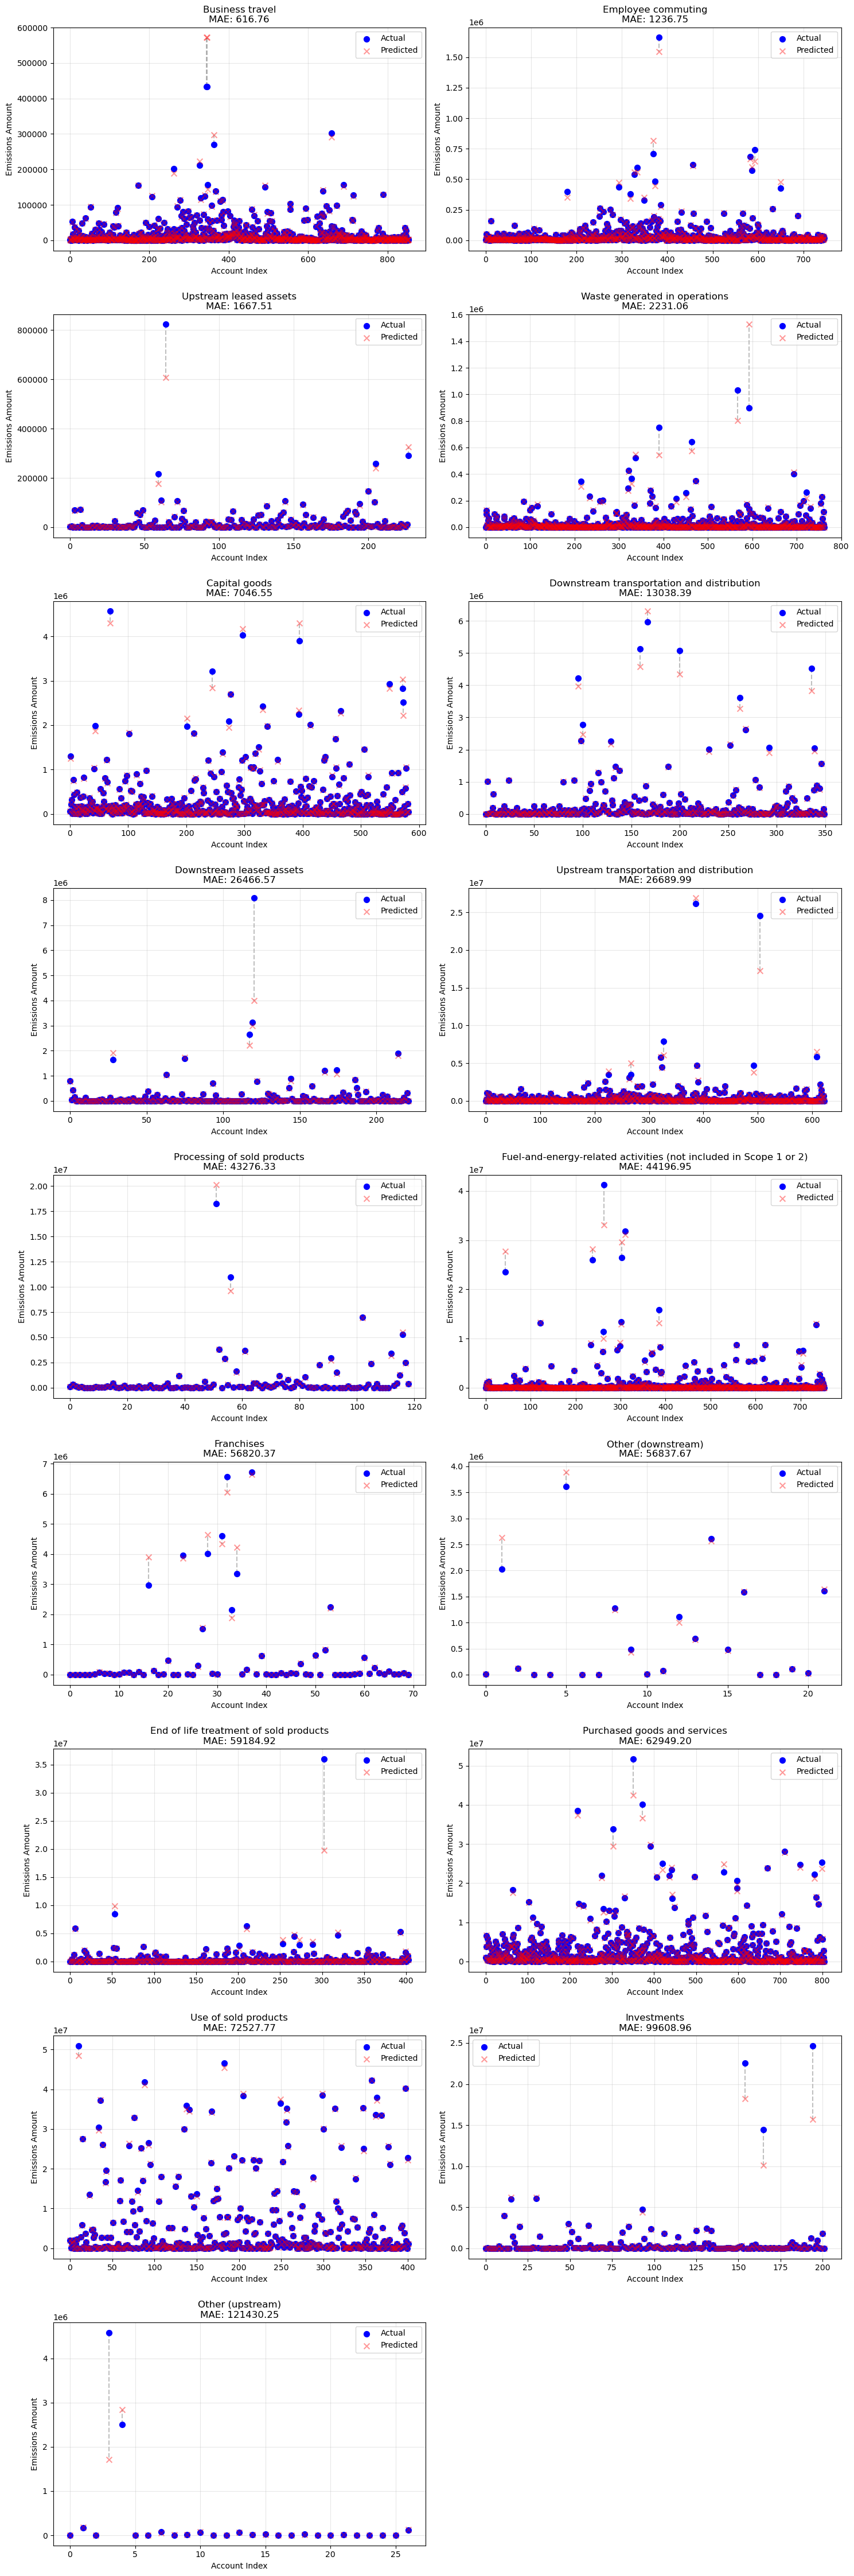

In [167]:
# Sort emission types by MAE
sorted_types = sorted(results_dict.items(), key=lambda x: x[1]['mae'])

# Create subplots based on number of valid emission types
n_types = len(sorted_types)
if n_types > 0:
    n_cols = 2
    n_rows = math.ceil(n_types / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axs = axs.flatten() if n_rows > 1 else [axs]

    # Plot results
    for idx, (emission_type, results) in enumerate(sorted_types):
        actuals = results['actuals']
        predictions = results['predictions']
        mae = results['mae']
        
        # Draw lines connecting actual to predicted values
        for i in range(len(actuals)):
            axs[idx].plot([i, i], [actuals[i], predictions[i]], 'gray', linestyle='--', alpha=0.5, zorder=1)
                # Create scatter plot for actuals (solid blue, behind predictions)
        axs[idx].scatter(range(len(actuals)), actuals, color='blue', label='Actual', 
                        zorder=2, s=50, alpha=1.0)
                # Create scatter plot for predictions (x marker, semi-transparent, in front)
        axs[idx].scatter(range(len(predictions)), predictions, color='red', marker='x', label='Predicted', 
                        zorder=3, s=50, alpha=0.4)
                axs[idx].set_title(f'{emission_type}\nMAE: {mae:.2f}')
        axs[idx].set_xlabel('Account Index')
        axs[idx].set_ylabel('Emissions Amount')
        axs[idx].legend()
        axs[idx].grid(True, alpha=0.3)

    # Remove empty subplots if any
    for idx in range(len(sorted_types), len(axs)):
        fig.delaxes(axs[idx])

    plt.tight_layout()
    plt.show()

    # Store MAE scores
    xgb_results = pd.DataFrame([
        {'Emission_Type': et, 'MAE_Score': res['mae']} 
        for et, res in sorted_types
    ])

else:
    print("No valid data to plot")

#### *Compare MAE Metric to Standard Deviation*

In [171]:
# Results analysis
if n_types > 0:
    plt.tight_layout()
    plt.show()

    # Create comprehensive results dataframe
    results_list = []
    for emission_type, results in sorted_types:
        actuals = results['actuals']
        mae = results['mae']
        std = np.std(actuals)
        mean = np.mean(actuals)
        
        results_list.append({
            'Emission_Type': emission_type,
            'MAE_Score': mae,
            'Standard_Deviation': std,
            'Mean': mean,
            'MAE_vs_STD_%': ((mae - std) / std) * 100,
            'MAE_vs_Mean_%': ((mae / mean) * 100) if mean != 0 else np.inf
        })

    xgb_results = pd.DataFrame(results_list)
    
    # Format the results
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    print("\nXGBoost Results Analysis:")

    print("\nSummary Statistics:")
    print(f"Average MAE vs STD %: {xgb_results['MAE_vs_STD_%'].mean():.2f}%")
    print(f"Average MAE vs Mean %: {xgb_results['MAE_vs_Mean_%'].mean():.2f}%")   
    
    print("\nDetailed Metrics for Each Emission Type:")
    print(xgb_results.to_string(index=False)) 

else:
    print("No valid data to plot")

<Figure size 640x480 with 0 Axes>


XGBoost Results Analysis:

Summary Statistics:
Average MAE vs STD %: -96.96%
Average MAE vs Mean %: 9.28%

Detailed Metrics for Each Emission Type:
                                                    Emission_Type  MAE_Score  Standard_Deviation       Mean  MAE_vs_STD_%  MAE_vs_Mean_%
                                                  Business travel     616.76            35186.98   15673.06        -98.25           3.94
                                               Employee commuting    1236.75            99727.36   37882.99        -98.76           3.26
                                           Upstream leased assets    1667.51            64746.91   20526.68        -97.42           8.12
                                    Waste generated in operations    2231.06            79388.03   27145.13        -97.19           8.22
                                                    Capital goods    7046.55           525368.76  269309.51        -98.66           2.62
                       Downst

## Random Forest

#### *Build the Model*

In [191]:
# Create empty lists to store results
mae_scores = []
emission_types = []
max_year_actuals = []
max_year_predictions = []

# Define numerical columns and gather features
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
feature_cols = [col for col in numerical_cols 
               if col not in ['Scope_3_emissions_amount', 'Year']]
selected_features = ['Year'] + feature_cols

# Dictionary to store results for each emission type
results_dict = {}

# Loop through each unique emission type
for emission_type in df['Scope_3_emissions_type'].unique():
    # Filter data for current emission type
    type_df = df[df['Scope_3_emissions_type'] == emission_type].copy()
    
    # Get the maximum year for this emission type
    max_year = type_df['Year'].max()
    
    # Split into train and test
    train_df = type_df[type_df['Year'] < max_year].copy()
    test_df = type_df[type_df['Year'] == max_year].copy()
    
    if len(train_df) == 0 or len(test_df) == 0:
        continue
        
    # Prepare features and target for training
    X_train = train_df[selected_features]
    y_train = train_df['Scope_3_emissions_amount']
    
    # Prepare features and target for testing
    X_test = test_df[selected_features]
    y_test = test_df['Scope_3_emissions_amount']
    
    # Train Random Forest model
    model = RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1  # Use all available cores
    )
    model.fit(X_train, y_train)
    
    # Make predictions
    predictions = model.predict(X_test)
    
    # Calculate MAE
    mae = mean_absolute_error(y_test, predictions)
    
    # Store results
    results_dict[emission_type] = {
        'mae': mae,
        'actuals': y_test.values.tolist(),
        'predictions': predictions.tolist()
    }

#### *Feature Importance*

In [194]:
# Feature importance analysis
rf_feature_importance = pd.DataFrame({
    'feature': selected_features,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)
    
results_dict[emission_type]['feature_importance'] = rf_feature_importance

rf_feature_importance

,feature,importance
9,Quantile_Scope_3_emissions,0.37
10,BoxCox_Scope_3_emissions,0.34
11,Robust_Scope_3_emissions,0.25
8,totalEquity_USD,0.03
1,account_id,0.00
3,grossProfit_USD,0.00
2,ebitda_USD,0.00
7,totalDebt_USD,0.00
6,longTermInvestments_USD,0.00
4,netIncome_USD,0.00


#### *Vizualize Results*

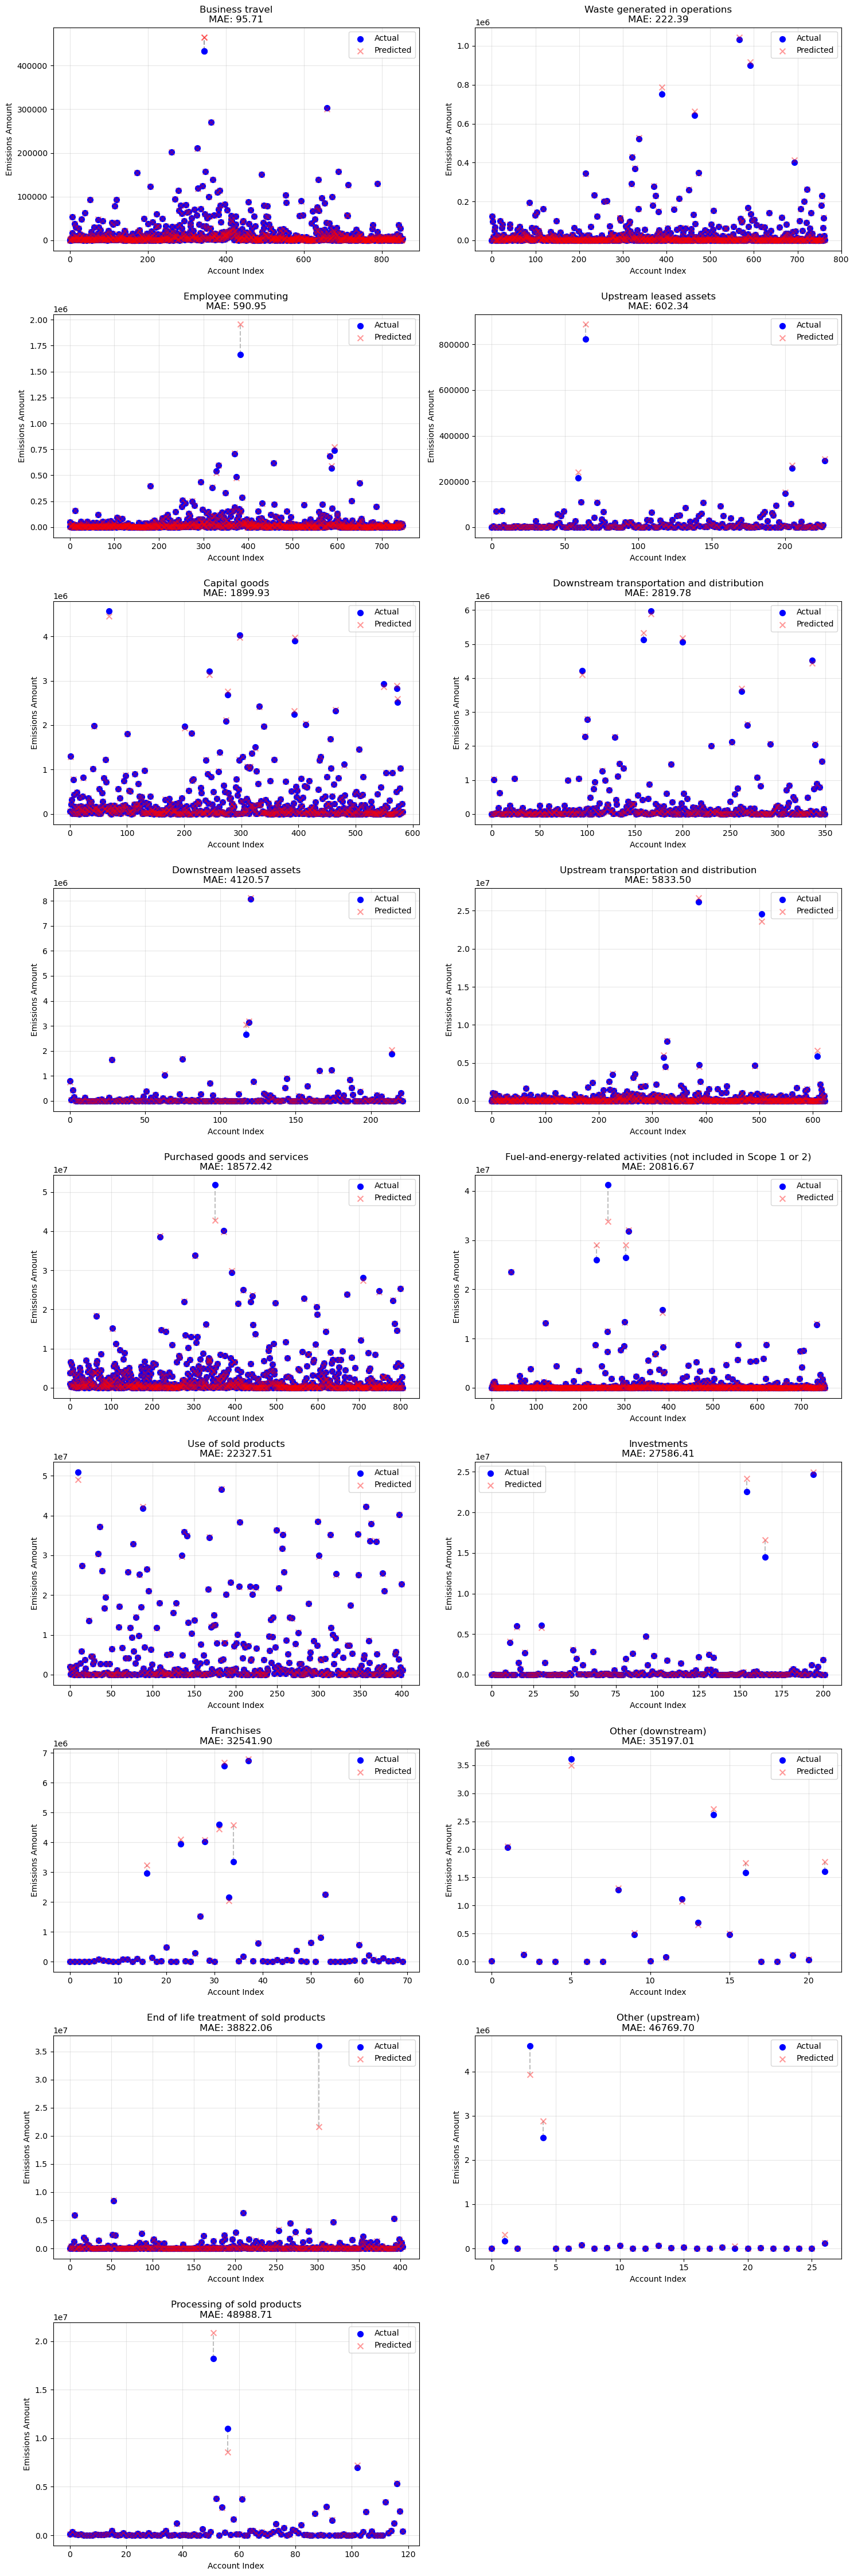

In [197]:
# Sort emission types by MAE
sorted_types = sorted(results_dict.items(), key=lambda x: x[1]['mae'])

# Create subplots based on number of valid emission types
n_types = len(sorted_types)
if n_types > 0:
    n_cols = 2
    n_rows = math.ceil(n_types / n_cols)
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axs = axs.flatten() if n_rows > 1 else [axs]

    # Plot results
    for idx, (emission_type, results) in enumerate(sorted_types):
        actuals = results['actuals']
        predictions = results['predictions']
        mae = results['mae']
        
        # Draw lines connecting actual to predicted values
        for i in range(len(actuals)):
            axs[idx].plot([i, i], [actuals[i], predictions[i]], 'gray', linestyle='--', alpha=0.5, zorder=1)
        # Create scatter plot for actuals (solid blue, behind predictions)
        axs[idx].scatter(range(len(actuals)), actuals, color='blue', label='Actual', 
                        zorder=2, s=50, alpha=1.0)
        # Create scatter plot for predictions (x marker, semi-transparent, in front)
        axs[idx].scatter(range(len(predictions)), predictions, color='red', marker='x', label='Predicted', 
                        zorder=3, s=50, alpha=0.4)
        axs[idx].set_title(f'{emission_type}\nMAE: {mae:.2f}')
        axs[idx].set_xlabel('Account Index')
        axs[idx].set_ylabel('Emissions Amount')
        axs[idx].legend()
        axs[idx].grid(True, alpha=0.3)

    # Remove empty subplots if any
    for idx in range(len(sorted_types), len(axs)):
        fig.delaxes(axs[idx])

    plt.tight_layout()
    plt.show()

    # Store MAE scores
    rf_results = pd.DataFrame([
        {'Emission_Type': et, 'MAE_Score': res['mae']} 
        for et, res in sorted_types
    ])

else:
    print("No valid data to plot")

#### *Compare MAE Metric to Standard Deviation*

In [199]:
# Results analysis
if n_types > 0:
    plt.tight_layout()
    plt.show()

    # Create comprehensive results dataframe
    results_list = []
    for emission_type, results in sorted_types:
        actuals = results['actuals']
        mae = results['mae']
        std = np.std(actuals)
        mean = np.mean(actuals)
        
        results_list.append({
            'Emission_Type': emission_type,
            'MAE_Score': mae,
            'Standard_Deviation': std,
            'Mean': mean,
            'MAE_vs_STD_%': ((mae - std) / std) * 100,
            'MAE_vs_Mean_%': ((mae / mean) * 100) if mean != 0 else np.inf
        })

    rf_results = pd.DataFrame(results_list)
    
    # Format the results
    pd.set_option('display.float_format', lambda x: '%.2f' % x)
    print("\nXGBoost Results Analysis:")

    print("\nSummary Statistics:")
    print(f"Average MAE vs STD %: {rf_results['MAE_vs_STD_%'].mean():.2f}%")
    print(f"Average MAE vs Mean %: {rf_results['MAE_vs_Mean_%'].mean():.2f}%")   
    
    print("\nDetailed Metrics for Each Emission Type:")
    print(rf_results.to_string(index=False)) 

else:
    print("No valid data to plot")

<Figure size 640x480 with 0 Axes>


XGBoost Results Analysis:

Summary Statistics:
Average MAE vs STD %: -98.76%
Average MAE vs Mean %: 3.66%

Detailed Metrics for Each Emission Type:
                                                    Emission_Type  MAE_Score  Standard_Deviation       Mean  MAE_vs_STD_%  MAE_vs_Mean_%
                                                  Business travel      95.71            35186.98   15673.06        -99.73           0.61
                                    Waste generated in operations     222.39            79388.03   27145.13        -99.72           0.82
                                               Employee commuting     590.95            99727.36   37882.99        -99.41           1.56
                                           Upstream leased assets     602.34            64746.91   20526.68        -99.07           2.93
                                                    Capital goods    1899.93           525368.76  269309.51        -99.64           0.71
                       Downst

### Compare XGBoost and Random Forest Models

In [209]:
# Create a comparison dataframe that outer joins the MAE results of each model
comparison_df = pd.merge(
    rf_results.rename(columns={'MAE_Score': 'RF_MAE'}),
    xgb_results.rename(columns={'MAE_Score': 'XGB_MAE'}),
    on='Emission_Type',
    how='outer'
)

# Calculate the difference and percentage difference
comparison_df['MAE_Difference'] = comparison_df['RF_MAE'] - comparison_df['XGB_MAE']
comparison_df['Better_Model'] = comparison_df.apply(
    lambda x: 'Random Forest' if x['RF_MAE'] < x['XGB_MAE'] else 'XGBoost', axis=1
)
comparison_df['Improvement_Percentage'] = abs(comparison_df['MAE_Difference'] / 
    comparison_df[['RF_MAE', 'XGB_MAE']].max(axis=1) * 100)

# Show summary statistics
print("\nOverall Summary:")
print("===============")
print(f"Random Forest better in {(comparison_df['Better_Model'] == 'Random Forest').sum()} cases")
print(f"XGBoost better in {(comparison_df['Better_Model'] == 'XGBoost').sum()} cases")
print(f"Average improvement percentage: {comparison_df['Improvement_Percentage'].mean():.2f}%")

# Format and display results for each emission type
print("\nDetailed Comparison by Emission Type:")
print("====================================")
for _, row in comparison_df.iterrows():
    print(f"\nEmission Type: {row['Emission_Type']}")
    print(f"Better Model: {row['Better_Model']}")
    print(f"Improvement: {row['Improvement_Percentage']:.2f}%")


Overall Summary:
Random Forest better in 16 cases
XGBoost better in 1 cases
Average improvement percentage: 62.23%

Detailed Comparison by Emission Type:

Emission Type: Business travel
Better Model: Random Forest
Improvement: 84.48%

Emission Type: Waste generated in operations
Better Model: Random Forest
Improvement: 90.03%

Emission Type: Employee commuting
Better Model: Random Forest
Improvement: 52.22%

Emission Type: Upstream leased assets
Better Model: Random Forest
Improvement: 63.88%

Emission Type: Capital goods
Better Model: Random Forest
Improvement: 73.04%

Emission Type: Downstream transportation and distribution
Better Model: Random Forest
Improvement: 78.37%

Emission Type: Downstream leased assets
Better Model: Random Forest
Improvement: 84.43%

Emission Type: Upstream transportation and distribution
Better Model: Random Forest
Improvement: 78.14%

Emission Type: Purchased goods and services
Better Model: Random Forest
Improvement: 70.50%

Emission Type: Fuel-and-ener

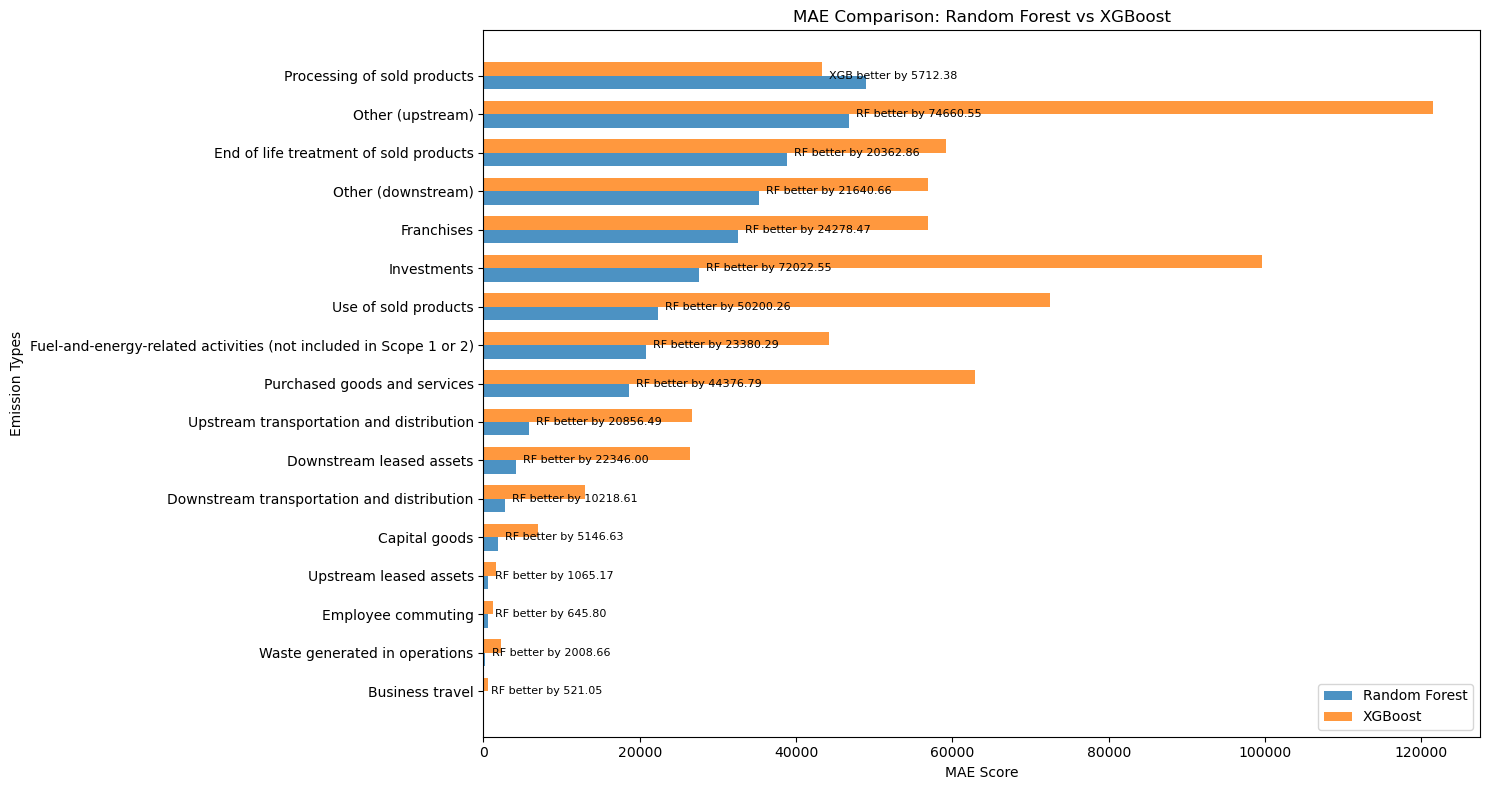

In [211]:
# Vizualize the comparison

plt.figure(figsize=(15, 8))
y = np.arange(len(comparison_df))
height = 0.35

# Create horizontal bars
rf_bars = plt.barh(y - height/2, comparison_df['RF_MAE'], height, label='Random Forest', alpha=0.8)
xgb_bars = plt.barh(y + height/2, comparison_df['XGB_MAE'], height, label='XGBoost', alpha=0.8)

# Add labels showing which model is better and by how much
for idx in range(len(comparison_df)):
    rf_mae = comparison_df['RF_MAE'].iloc[idx]
    xgb_mae = comparison_df['XGB_MAE'].iloc[idx]
    difference = abs(rf_mae - xgb_mae)
    
    if rf_mae < xgb_mae:
        better_model = 'RF better by'
        x_pos = rf_mae
    else:
        better_model = 'XGB better by'
        x_pos = xgb_mae
    
    # Add text label to indicate which performed better and by how much
    plt.text(x_pos, y[idx], 
             f'  {better_model} {difference:.2f}',  # Added space for separation
             va='center',
             ha='left',
             fontsize=8)

plt.ylabel('Emission Types')
plt.xlabel('MAE Score')
plt.title('MAE Comparison: Random Forest vs XGBoost')
plt.yticks(y, comparison_df['Emission_Type'])
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

#### **Analyzing MAE and Model Performance**

For both models, the MAE is significantly lower than the standard deviation, which indicates strong prediction performance. 

Standard Deviation (σ) represents the natural variability and spread of the data and is used to indicate how much actual values deviate from the mean. In general, the higher the SD, the harder it is to predict a target. While the SD was dramatically reduced in the previous outlier and normalization process, the SD remained high across emission types and primary activies. The MAE represents the average prediction error with the same unit as the target, which is emissions amount in case. A quick review of the plot outputs allows you to visually see how close each prediction was and the MAE metric for each emissions type is the average of all predictions within that category.

Thus, because the MAE < σ (negative MAE_vs_STD_%):
- The model's predictions are more accurate than what you'd expect from the natural variation in the data
- The model has successfully captured the underlying patterns beyond random variation
- The predictions are more reliable than simply using the mean value
- The model is performing well relative to the inherent variability of the data

Comparing XGBoost to Random Forest, it's clear that Random Forest is the better suited model in this specific scenario, with pretty precise predictions. I find this curious because the feature importance shows that the Quantile-transformed Emission amount was an important feature in helping make predictions with the XGBoost model, but random forest performed well with very minimal feature importance, indicating time series alone helped with these predictions. Considering the model's average error is over 90% lower than the natural variation in the data, it is a strong indication that the model has learned meaningful patterns in the data.

#### **Further Research**

1. Benchmarking against XGBoost and Random Forest
2. Enhanced features and validation to predict targets without time series evaluation
3. Continued normalization and outlier analysis with possible imputation
4. Testing models on nulls and testing ensemble approaches
5. Testing Deep Learning and Neural Networks:
    - More complex pattern recognition (identify noin-linear relationships, adapt to changing patterns)
    - Better time series prediction
    - Better handling of high-dimensional data with automatic feature extraction
    - Better incorporate categorical data like Primary activity or Sector